# Transfer Learning for Image Classification

In [7]:
# general
import glob
from pathlib import Path
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# torch
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# images
import cv2 as cv

# scikit
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
# setup 
sns.set(
    style="whitegrid",
    palette="muted",
    font_scale=1.2
)

# color palette
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# seeding everything
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
train_path = "data/GTSRB/Final_Training/Images/*"
train_folder = sorted(glob.glob(train_path))

In [10]:
train_folder

['data/GTSRB/Final_Training/Images/00000',
 'data/GTSRB/Final_Training/Images/00001',
 'data/GTSRB/Final_Training/Images/00002',
 'data/GTSRB/Final_Training/Images/00003',
 'data/GTSRB/Final_Training/Images/00004',
 'data/GTSRB/Final_Training/Images/00005',
 'data/GTSRB/Final_Training/Images/00006',
 'data/GTSRB/Final_Training/Images/00007',
 'data/GTSRB/Final_Training/Images/00008',
 'data/GTSRB/Final_Training/Images/00009',
 'data/GTSRB/Final_Training/Images/00010',
 'data/GTSRB/Final_Training/Images/00011',
 'data/GTSRB/Final_Training/Images/00012',
 'data/GTSRB/Final_Training/Images/00013',
 'data/GTSRB/Final_Training/Images/00014',
 'data/GTSRB/Final_Training/Images/00015',
 'data/GTSRB/Final_Training/Images/00016',
 'data/GTSRB/Final_Training/Images/00017',
 'data/GTSRB/Final_Training/Images/00018',
 'data/GTSRB/Final_Training/Images/00019',
 'data/GTSRB/Final_Training/Images/00020',
 'data/GTSRB/Final_Training/Images/00021',
 'data/GTSRB/Final_Training/Images/00022',
 'data/GTSR

In [11]:
# helpers
def load_image(img_path, resize=True):
    img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)

    if resize:
        img = cv.resize(img, (64, 64), interpolation=cv.INTER_AREA)
    
    return img

def show_image(img_path):
    img = load_image(img_path)
    plt.imshow(img)
    plt.axis('off')

def show_sign_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    # putting the images on the correct format: 
    # batch x channels x width x height
    images = images.permute(0, 3, 1, 2)
    grid_img = torchvision.utils.make_grid(images, nrow=11)
    plt.figure(figsize=(24, 12))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

/tmp/ipykernel_8942/2306074146.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  images = torch.as_tensor(images)


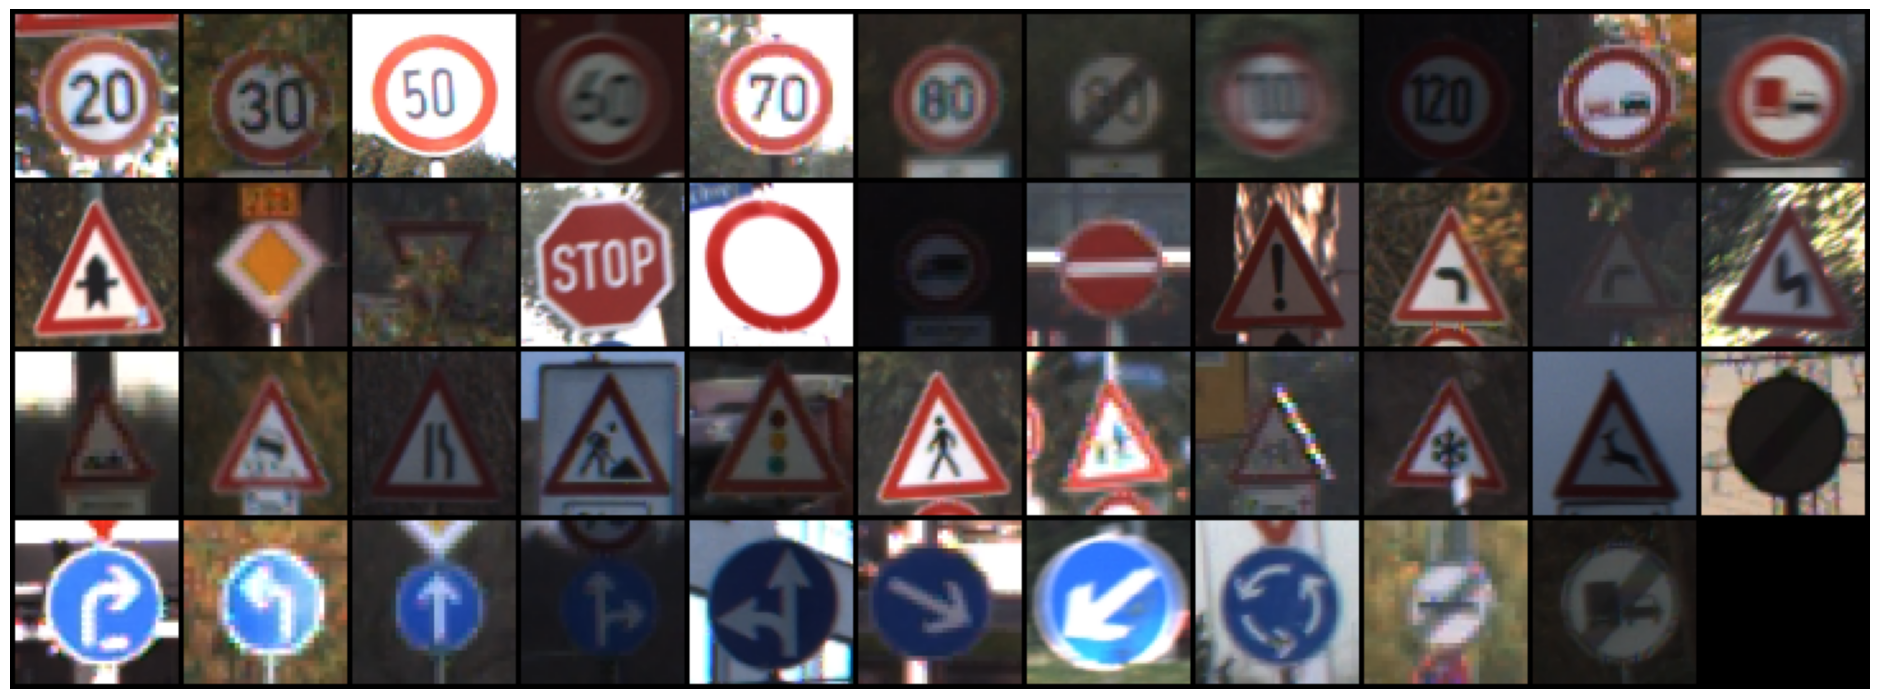

In [12]:
sample_images = [np.random.choice(glob.glob(f'{tf}/*ppm')) for tf in train_folder]
show_sign_grid(sample_images)

We have a total of 40 classes, but here will be looking just at some classes:
- priority_road: 12
- give_way: 13
- stop: 14
- no_entry: 17

In [13]:
DATA_DIR = Path('data', 'gtsrb_training')
DATASETS = ['train', 'val', 'test']
CLASSES_NAMES = ['priority_road', 'give_way', 'stop', 'no_entry']
CLASSES_INDICES = [12, 13, 14, 17]

for dataset in DATASETS:
    for classe in CLASSES_NAMES:
        DATA_DIR.joinpath(dataset, classe).mkdir(parents=True, exist_ok=True)


If you run this code more than one time in a row, will end up with duplicate images on those folders

In [14]:
# we'll reserve 80% of the images for training, 10% validation
# 10% for test
OLD_DATA_PATH = "data/GTSRB/Final_Training/Images/"
for i, class_idx in enumerate(CLASSES_INDICES):
    origin_folder_name = str(class_idx).zfill(5)
    image_paths = np.array(glob.glob(OLD_DATA_PATH + origin_folder_name + '/*.ppm'))
    print("{}: {}".format(CLASSES_NAMES[i], len(image_paths)))
    
    # randomize our sample to do the split
    np.random.shuffle(image_paths)

    # splitting the data first in 80% and after in 90%
    # 80/10/10 
    dataset_split = np.split(
        image_paths,
        indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
    )
    
    dataset_data = zip(DATASETS, dataset_split)
    
    for dataset_section, img_paths in dataset_data:
        for img_path in img_paths:
            shutil.copy(img_path, DATA_DIR.joinpath(dataset_section, CLASSES_NAMES[i]))


priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


In [15]:
# collecting means and std of pixels on training images
# for each of the classes we have
transformers_dataset = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
])
image_dataset = torchvision.datasets.ImageFolder(root="data/gtsrb_training/train/", transform=transformers_dataset)

In [16]:
dataloader = DataLoader(image_dataset, 
                            batch_size=len(image_dataset),
                            shuffle=False,
                            num_workers=3)

In [17]:
def mean_std_loader(loader):
    images, labels = next(iter(loader))
    mean, std = images.mean([0, 2, 3]), images.std([0, 2, 3])
    return mean, std

mean, std = mean_std_loader(dataloader)
print("mean: {}, std: {}".format(mean, std))

mean: tensor([0.3885, 0.3477, 0.3460]), std: tensor([0.2896, 0.2787, 0.2800])


mean: tensor([0.3995, 0.3543, 0.3492]), std: tensor([0.2919, 0.2811, 0.2810])

In [18]:
mean_nums = [0.3995, 0.3543, 0.3492]
std_nums = [0.2919, 0.2811, 0.2810]

In [19]:
# transformers for the actually training
transformers_train_val_test = {
    "train": transforms.Compose([ 
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_nums, std=std_nums)
    ]),
    "val": transforms.Compose([ 
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_nums, std=std_nums)
    ]),
    "test": transforms.Compose([ 
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_nums, std=std_nums)
    ]),
}

In [20]:
image_datasets = {
    d: torchvision.datasets.ImageFolder(f"{DATA_DIR}/{d}", transformers_train_val_test[d]) for d in DATASETS
}

In [21]:
data_lodaers = {
    d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=6)
    for d in DATASETS
}

In [22]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets["train"].classes
dataset_sizes

{'train': 6994, 'val': 1466, 'test': 1472}

In [23]:
# using a pre-trained model
def create_model(n_classes):
    
    if torch.cuda.is_available:
        device = 'cuda'
    else:
        device = 'cpu'

    model = torchvision.models.resnet34(pretrained=True)

    # changing the output layer
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

    return model.to(device)

In [24]:
base_model = create_model(len(class_names))
base_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
def train_epoch(
    model,
    dataloader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples,
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    scheduler.step()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
def eval_model(model, dataloader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
from collections import defaultdict


def train_model(model, dataloaders, dataset_sizes, device, n_epochs=3):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(n_epochs):
        print('Epoch {}:{}'.format(epoch + 1, n_epochs))
        print('-' * 10)

        train_acc, train_loss = train_epoch(
            model, dataloaders['train'], loss_fn, optimizer, device, scheduler, dataset_sizes['train']
        )

        print('Train loss {} accuracy {}'.format(train_loss, train_acc))

        val_acc, val_loss = train_epoch(
            model, dataloaders['val'], loss_fn, optimizer, device, scheduler, dataset_sizes['val']
        )

        print('Val loss {} accuracy {}'.format(val_loss, val_acc))

        history["train_acc"].append(train_acc)
        history["train_loss"].append(train_loss)
        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(
                model.state_dict(),
                "best_model_state.bin"
            )

    print('Best val accuracy: {}'.format(best_accuracy))

    model.load_state_dict(torch.load('best_model_state.bin'))

    return model, history




In [28]:
base_model, history = train_model(base_model, data_lodaers, dataset_sizes, device)

Epoch 1:3
----------
Train loss 0.3478317136799307 accuracy 0.885759222190449
Val loss 0.028227745001317715 accuracy 0.9945429740791268
Epoch 2:3
----------
Train loss 0.15537454167923334 accuracy 0.9522447812410638
Val loss 0.016124839672893878 accuracy 0.9959072305593452
Epoch 3:3
----------
Train loss 0.09971872093661595 accuracy 0.9694023448670289
Val loss 0.013087463449052825 accuracy 0.9972714870395635
Best val accuracy: 0


In [29]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    
    plt.axis('off')


In [30]:
# showing predictions
def show_predictions(model, class_names, n_images):
    model = model.eval()
    images_handeled = 0
    plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_lodaers['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            for j in range(inputs.shape[0]):
                images_handeled += 1
                ax = plt.subplot(2, n_images//2, images_handeled)
                ax.set_title('{}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                ax.axis('off')

                if images_handeled == n_images:
                    return

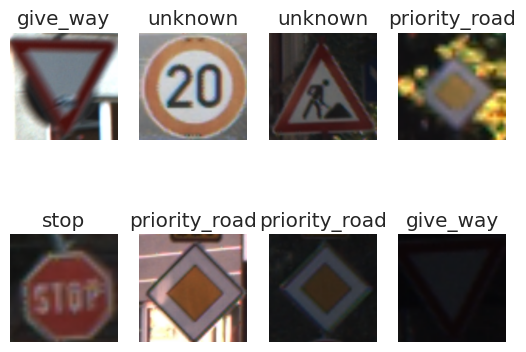

In [31]:
show_predictions(base_model, class_names, n_images=8)

In [32]:
# getting predictions
def getting_predictions(model, data_loader):
    model = model.eval()
    prediction = []
    real_values = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            prediction.extend(preds)
            real_values.extend(labels)
    
    predictions = torch.as_tensor(prediction).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    return predictions, real_values



In [33]:
y_pred, y_true = getting_predictions(base_model, data_lodaers["test"])

In [34]:
print(classification_report(y_true, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       407
     no_entry       1.00      1.00      1.00       206
priority_road       1.00      1.00      1.00       406
         stop       1.00      1.00      1.00       148
      unknown       1.00      1.00      1.00       305

     accuracy                           1.00      1472
    macro avg       1.00      1.00      1.00      1472
 weighted avg       1.00      1.00      1.00      1472



In [35]:
# show confusion matrix
def show_confusion_matrix(confusion_matrix, class_names):
    cm = confusion_matrix.copy()
    cell_counts = cm.flatten()
    cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

    cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
    cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

    df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

    hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap='Blues')
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
    plt.ylabel('True Sign')
    plt.xlabel('Predicted Sign')

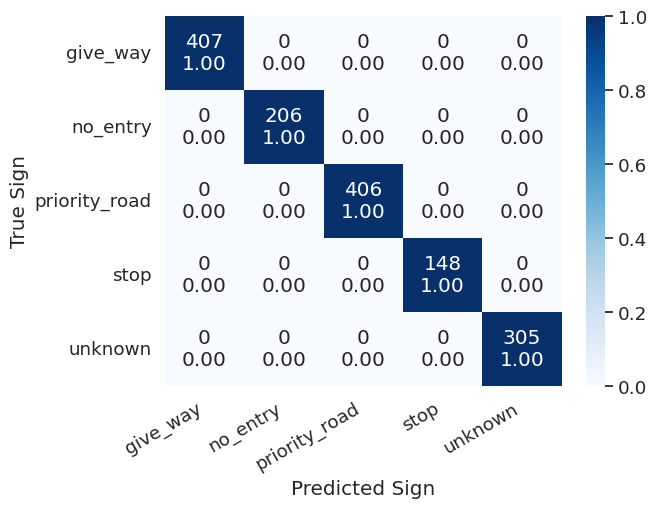

In [36]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

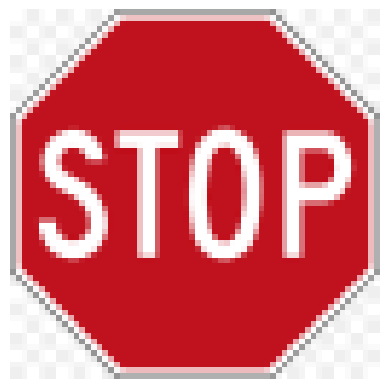

In [37]:
# classifying unseen images
show_image("data/unseen_placas_transito/png-transparent-stop-sign-traffic-sign-coloring-book-manual-on-uniform-traffic-control-devices-afraid-child-text-rectangle-thumbnail.png")

In [38]:
def predict_proba(model, image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    img = transformers_train_val_test["test"](img).unsqueeze(0)

    pred = model(img.to(device))
    pred = F.softmax(pred, dim=1)
    return pred.detach().cpu().numpy().flatten()

In [39]:
pred = predict_proba(base_model, 'data/unseen_placas_transito/png-transparent-stop-sign-traffic-sign-coloring-book-manual-on-uniform-traffic-control-devices-afraid-child-text-rectangle-thumbnail.png')
pred

array([8.62550223e-04, 1.14362715e-02, 3.35017475e-03, 9.80288923e-01,
       4.06212267e-03], dtype=float32)

In [40]:
def show_predictions_confidence(pred, class_names):
    pred_df = pd.DataFrame({
        "class_names": class_names,
        "values": pred
    })
    sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
    plt.xlim([0, 1])

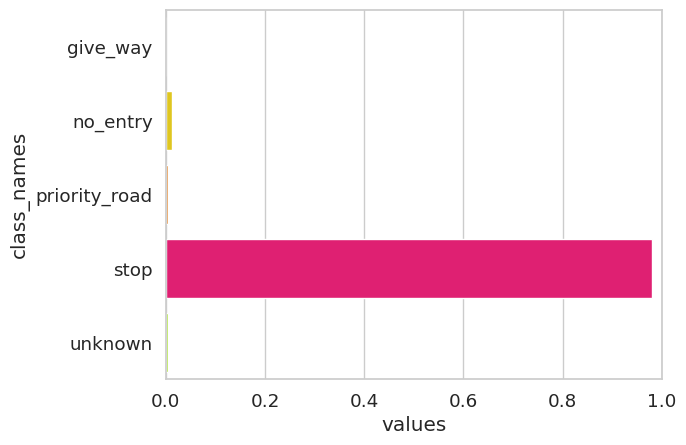

In [41]:
show_predictions_confidence(pred, class_names)

In [42]:
# classyfing unknown traffic sign
# adding class 'unknown'
unknown_indices = [
    i for i, f in enumerate(train_folder)
    if i not in CLASSES_INDICES
]

len(unknown_indices)

39

In [43]:
DATASETS

['train', 'val', 'test']

In [44]:
# creating a folder for unknown
for dataset in DATASETS:
    DATA_DIR.joinpath(dataset, 'unknown').mkdir(parents=True, exist_ok=True)


In [45]:
DATA_DIR

PosixPath('data/gtsrb_training')

In [46]:
# we'll reserve 80% of the images for training, 10% validation
# 10% for test
OLD_DATA_PATH = "data/GTSRB/Final_Training/Images/"
for ui in unknown_indices:
    origin_folder_name = str(ui).zfill(5)
    image_paths = np.array(glob.glob(OLD_DATA_PATH + origin_folder_name + '/*.ppm'))
    image_paths = np.random.choice(image_paths, 50)
    
    # splitting the data first in 80% and after in 90%
    # 80/10/10 
    dataset_split = np.split(
        image_paths,
        indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
    )
    
    dataset_data = zip(DATASETS, dataset_split)
    
    for dataset_section, img_paths in dataset_data:
        for img_path in img_paths:
            shutil.copy(img_path, DATA_DIR.joinpath(dataset_section, "unknown"))
